In [72]:
from dotenv import load_dotenv
load_dotenv()
from langchain_tavily import TavilySearch
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper, ArxivAPIWrapper

In [73]:
api_wrapper_arxiv = ArxivAPIWrapper(top_k_results=2, doc_content_chars_max=500)
arxiv = ArxivQueryRun(api_wrapper=api_wrapper_arxiv)
api_wrapper_wiki = WikipediaAPIWrapper(top_k_results=2, doc_content_chars_max=500)
wiki = WikipediaQueryRun(api_wrapper=api_wrapper_wiki)


tavily = TavilySearch()



In [74]:
## custom functions
def multiply(a: float, b: float) -> float:
    """
    Multiply two numbers.

    Args:
        a (float): The first number.
        b (float): The second number.

    Returns:
        float: The product of a and b.
    """
    return a * b

def add(a: float, b: float) -> float:
    """
    Add two numbers.

    Args:
        a (float): The first number.
        b (float): The second number.

    Returns:
        float: The sum of a and b.
    """
    return a + b

def divide(a: float, b: float) -> float:
    """
    Divide one number by another.

    Args:
        a (float): The numerator.
        b (float): The denominator (must not be zero).

    Returns:
        float: The result of a divided by b.

    Raises:
        ValueError: If b is zero.
    """
    if b == 0:
        raise ValueError("Denominator b must not be zero.")
    return a / b


tools=[arxiv,wiki,tavily,add,multiply,divide]


In [75]:
from langchain_groq import ChatGroq
from langchain_openai import ChatOpenAI
#llm = ChatGroq(model='qwen-qwq-32b') #deepseek-r1-distill-llama-70b,llama-3.1-8b-instant
llm = ChatOpenAI(model='gpt-4.1-nano')

llm_with_tools = llm.bind_tools(tools)

In [76]:
from pprint import pprint
from langchain_core.messages import HumanMessage, AIMessage
llm_with_tools.invoke([HumanMessage("What is recent ai news?")]).tool_calls


[{'name': 'tavily_search',
  'args': {'query': 'recent AI news', 'search_depth': 'basic'},
  'id': 'call_5K3Euz87FMmS2nmAICUsgi2L',
  'type': 'tool_call'}]

In [77]:
# State Schema
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

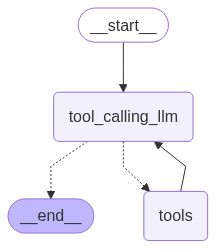

In [78]:
## chatbot with langgraph
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

## node definition
def tool_calling_llm(state:State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

## graph definition
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition,
)
builder.add_edge("tools","tool_calling_llm")

## graph visualization
graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))




In [79]:
messages = graph.invoke(
    {
        "messages":HumanMessage(
            content='provide me latest AI News, add 10 and 20 and divide by 2'
        )
    }
)
for message in messages['messages']:
    message.pretty_print()

================================ Human Message =================================

provide me latest AI News, add 10 and 20 and divide by 2
================================== Ai Message ==================================
Tool Calls:
  tavily_search (call_ziVn9WLEfFO1rjTx00HGtieD)
 Call ID: call_ziVn9WLEfFO1rjTx00HGtieD
  Args:
    query: latest AI news
    search_depth: basic
  add (call_xSm9X32ufA8gBgGPH20WaARF)
 Call ID: call_xSm9X32ufA8gBgGPH20WaARF
  Args:
    a: 10
    b: 20
================================= Tool Message =================================
Name: tavily_search

{"query": "latest AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.wsj.com/tech/ai?gaa_at=eafs&gaa_n=ASWzDAjASSuI28PxQk8-1ACPoOAV7z7pMLrl8doTted0d7fKZ3XemT8PhGP1&gaa_ts=686e536b&gaa_sig=llmoNda5lF1t_Eo2aR101-pG5315ErjtxUYMX-Oyc2hNHeAnd3tgNrko68AbC9BkXypPjvdocZtRAl0qe0bDEQ%3D%3D", "title": "Artificial Intelligence - Latest AI News and Analysis - WSJ.com", "con

In [80]:
messages = graph.invoke(
    {
        "messages":HumanMessage(
            content='what is machine learning?'
        )
    }
)
for message in messages['messages']:
    message.pretty_print()

================================ Human Message =================================

what is machine learning?
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_3YrdkVEQd6921nn8DWf6PCT4)
 Call ID: call_3YrdkVEQd6921nn8DWf6PCT4
  Args:
    query: machine learning
================================= Tool Message =================================
Name: wikipedia

Page: Machine learning
Summary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalise to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.
ML fi
================================== Ai Message ==================================

### Agent Memory



In [81]:
messages = graph.invoke(
    {
        "messages":HumanMessage(
            content='what is 5 plus 8'
        )
    }
)
for message in messages['messages']:
    message.pretty_print()

================================ Human Message =================================

what is 5 plus 8
================================== Ai Message ==================================
Tool Calls:
  add (call_W9yOq6wT2GwZHoccGp525ZLA)
 Call ID: call_W9yOq6wT2GwZHoccGp525ZLA
  Args:
    a: 5
    b: 8
================================= Tool Message =================================
Name: add

13.0
================================== Ai Message ==================================

The sum of 5 plus 8 is 13.


In [82]:
messages = [HumanMessage(content='Divide that by 5')]
messages = graph.invoke(
    {
        "messages":messages
        
    }
)
for message in messages['messages']:
    message.pretty_print()

================================ Human Message =================================

Divide that by 5
================================== Ai Message ==================================
Tool Calls:
  divide (call_y8q3ejM9aF3ZcYiou79zV38l)
 Call ID: call_y8q3ejM9aF3ZcYiou79zV38l
  Args:
    a: 100
    b: 5
================================= Tool Message =================================
Name: divide

20.0
================================== Ai Message ==================================

The result of dividing 100 by 5 is 20.


### Memory Saver
- LangGraph can use a checkPointer to  automatically save the graph state after each step.<br>
- This built-in persistence layer gives us memory, allowing LangGraph to pick up from the last state.<br>
- One of the easiest checkPointer to use is the MemorySaver, an in-memory key-value store for Graph state.<br>
- All we need to do is simply compile the graph with a checkPointer, and our graph hs memory!!<br>




![image.png](image.png)

In [83]:
## chatbot with langgraph
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

## node definition
def tool_calling_llm(state:State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

## graph definition
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition,
)
builder.add_edge("tools","tool_calling_llm")



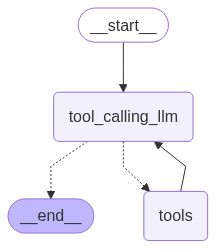

In [84]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()
graph_memory = builder.compile(checkpointer=memory) ## checkPointer is used to save the state of the graph in memory

display(Image(graph_memory.get_graph().draw_mermaid_png()))



In [85]:
## Specify the thread

config = { 'configurable': { 'thread_id': '123' } }

## Specify an input

messages = [HumanMessage(content='what is 12 plus 13')]

messages = graph_memory.invoke({'messages':messages},config=config)

for message in messages['messages']:
    message.pretty_print()

================================ Human Message =================================

what is 12 plus 13
================================== Ai Message ==================================
Tool Calls:
  add (call_1BXPY0nzDafUd43pVYBW6SCB)
 Call ID: call_1BXPY0nzDafUd43pVYBW6SCB
  Args:
    a: 12
    b: 13
================================= Tool Message =================================
Name: add

25.0
================================== Ai Message ==================================

12 plus 13 equals 25.


In [86]:
messages = [HumanMessage(content='add that number to 33')]

messages = graph_memory.invoke({'messages':messages},config=config)

for message in messages['messages']:
    message.pretty_print()

================================ Human Message =================================

what is 12 plus 13
================================== Ai Message ==================================
Tool Calls:
  add (call_1BXPY0nzDafUd43pVYBW6SCB)
 Call ID: call_1BXPY0nzDafUd43pVYBW6SCB
  Args:
    a: 12
    b: 13
================================= Tool Message =================================
Name: add

25.0
================================== Ai Message ==================================

12 plus 13 equals 25.
================================ Human Message =================================

add that number to 33
================================== Ai Message ==================================
Tool Calls:
  add (call_E71kw84gZaOtwb44hoy1Tv0h)
 Call ID: call_E71kw84gZaOtwb44hoy1Tv0h
  Args:
    a: 25
    b: 33
================================= Tool Message =================================
Name: add

58.0
================================== Ai Message ==================================

25 plus 33 equals

In [87]:
messages = [HumanMessage(content='divide that by 2')]

messages = graph_memory.invoke({'messages':messages},config=config)

for message in messages['messages']:
    message.pretty_print()

================================ Human Message =================================

what is 12 plus 13
================================== Ai Message ==================================
Tool Calls:
  add (call_1BXPY0nzDafUd43pVYBW6SCB)
 Call ID: call_1BXPY0nzDafUd43pVYBW6SCB
  Args:
    a: 12
    b: 13
================================= Tool Message =================================
Name: add

25.0
================================== Ai Message ==================================

12 plus 13 equals 25.
================================ Human Message =================================

add that number to 33
================================== Ai Message ==================================
Tool Calls:
  add (call_E71kw84gZaOtwb44hoy1Tv0h)
 Call ID: call_E71kw84gZaOtwb44hoy1Tv0h
  Args:
    a: 25
    b: 33
================================= Tool Message =================================
Name: add

58.0
================================== Ai Message ==================================

25 plus 33 equals